<a href="https://colab.research.google.com/github/Hyeonmin64/2024-Individual-study-MAS495-/blob/main/Coding_exercise_1907_12925.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from collections import OrderedDict
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D

from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
#### Setting blocks
pi = torch.pi

In [ ]:
#### Notes
## Observation: Using mesh grid.
## First, Draw the mesh. And obtain certain tensor grid.
## Second, we need to (tensor grid) > (domain tensor) > (output tensor; NN(input; from domain tensor))
## Third, then we can compute the observation loss.
## In this paper, losses are not normalized by the quantity. So, In this code I additionally applied normalization.



In [ ]:
# the deep neural network
# It only poses DNN structure, we first build NN and IP separately.

class DNN(torch.nn.Module):
    def __init__(self, layers, activation, dim_parameter):
        super(DNN, self).__init__()

        ## layers, list of integers, include also input-layer and output-layer. so we name it as [3, @@, @@, ..., 1]
        # parameters
        self.depth = len(layers) - 1

        # set up layer order dict
        self.activation = activation
        self.parameter = nn.Parameter(torch.ones(dim_parameter, 1), requires_grad=True)

        layer_list = []

        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' %i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' %i, self.activation))

        layer_list.append(('layer_%d' %(self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))

        layerDict = OrderedDict(layer_list)

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [ ]:
############################################
#### Experiments: 1.1. 1D transport equation

# Set number of data points
N_0 = 200
N_b = 40
N_t = 40
N_x = 100

# Set boundary
# Actually, it doesn't have boundary, but we restrict it to [0, 1] compact domain.
tmin = 0
tmax = 1
xmin = 0
xmax = 1


# Lower bounds
lb = [tmin, xmin]
# Upper bounds
ub = [tmax, xmax]

# Set random seed for reproducible results
torch.manual_seed(1)

## the physics-guided neural network, with 1D-transport equation.

class PINN_TP():
    def __init__(self, dnn, observation):
        super(PINN_TP, self).__init__()

        self.dnn = dnn
        self.observation = observation  # Since TP involves (t, x), It consists of (N*M, 3) dimension tensor, [T_grid_tensor, X_grid_tensor, U_grid_tensor].
        self.hist = [[], [], [], [], [], []]  # 6 by N 'list' which contains 'number' [IC, BC, Res, Obs, Total, parameter] order.


    # Define initial condtion
    def fun_u_0(self, x):

        n = x.shape[0]
        value = torch.zeros(1,1)

        for i in range(n):
            x_i = x[i:(i+1), :]

            if x_i >= 0.1 and x_i <= 0.5:
                v_i = torch.sin((10/4)*pi*(x_i-0.1))**4
            else:
                v_i = torch.zeros(1,1)

            value = torch.cat((value, v_i), dim=0)
        value = value[1:, :]
        return value


    # Define boundary condition
    def fun_u_b(self, t, x):

        n = x.shape[0]
        return torch.zeros(n,1)


    # Define residual of the PDE
    def fun_r(self, t, x, u, u_t, u_x):

        return u_t + (self.dnn.parameter)*(u_x)


    def get_u(self, t, x):

        u = self.dnn(torch.cat([t, x], dim=1))
        return u


    def get_res(self, t, x):  # takes size-n tensor separately.

        t = t.clone().detach().requires_grad_(True)
        x = x.clone().detach().requires_grad_(True)

        u = self.get_u(t, x)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        return self.fun_r(t, x, u, u_t, u_x)


    def get_loss_0(self):

        t_0 = torch.zeros(N_0+1, 1)
        x_0 = torch.linspace(lb[1], ub[1], N_0+1).view(N_0+1, 1)  # torch.linspace(0, 1, 100+1) = tensor([0, 1e-2, 2e-2, ... , 1]); size with 101

        u_0 = self.fun_u_0(x_0) # N_0+1 by 1 tensor
        loss_0 = torch.mean(torch.square(self.get_u(t_0, x_0)-u_0))

        return loss_0

    def get_loss_b(self):

        t_b_1 = torch.linspace(lb[0], ub[0], N_b+1).view(N_b+1, 1)
        t_b_1 = t_b_1[1:, :]
        t_b = torch.cat((t_b_1, t_b_1), dim=0)  # (2*N_b by 2)-tensor
        x_b_1 = torch.ones(N_b, 1)*lb[1]
        x_b_2 = torch.ones(N_b, 1)*ub[1]
        x_b = torch.cat((x_b_1, x_b_2), dim=0)  # (2*N_b by 2)-tensor

        u_b = self.fun_u_b(t_b, x_b)

        loss_b = torch.mean(torch.square(self.get_u(t_b, x_b)-u_b))

        return loss_b


    def get_loss_r(self):

        tspace = np.linspace(lb[0], ub[0], N_t+1)
        xspace = np.linspace(lb[1], ub[1], N_x+1)

        ## We want to observe only the residual data.
        tspace = np.delete(tspace, 0)  # Pop out the IC observation
        xspace = np.delete(xspace, 0)  # Pop out the BC Observation
        xspace = np.delete(xspace, -1)  # Pop out the BC Observation

        T, X = np.meshgrid(tspace, xspace)
        data_grid = np.vstack([T.flatten(),X.flatten()]).T  # <class 'numpy.ndarray'>, it is float64
        data_grid_tensor = torch.tensor(data_grid).to(torch.float32)  # torch is float32, so convert data type of tensor to float32

        t_r = data_grid_tensor[:, 0:1]
        x_r = data_grid_tensor[:, 1:2]
        loss_r = torch.mean(torch.square(self.get_res(t_r, x_r)))

        return loss_r


    def get_loss_obs(self):

        T_grid_tensor = self.observation[:, 0:1]
        X_grid_tensor = self.observation[:, 1:2]
        U_obs_tensor = self.observation[:, 2:3]
        U_valued_tensor = self.get_u(T_grid_tensor, X_grid_tensor)

        loss_obs = torch.mean(torch.square(U_obs_tensor - U_valued_tensor))

        return loss_obs

    def get_loss(self):  # Loss should be 'tensor'.

        loss_0 = self.get_loss_0()
        self.hist[0].append(loss_0.item())  # Store float num

        loss_b = self.get_loss_b()
        self.hist[1].append(loss_b.item())

        loss_r = self.get_loss_r()
        self.hist[2].append(loss_r.item())

        loss_obs = self.get_loss_obs()
        self.hist[3].append(loss_obs.item())

        loss = loss_0 + loss_b + loss_r + loss_obs
        self.hist[4].append(loss.item())

        self.hist[5].append(self.dnn.parameter.item())

        return loss

In [ ]:
#### TP analytic solution
## parameter = pi/10
## if u(0, x) = f(x), then u(t, x) = f(x-p*t); p=pi/10

def TP_analytic_sol(t, x):
    loc = x-(pi/10)*t
    n = loc.shape[0]
    value = torch.zeros(1,1)

    for i in range(n):
        loc_i = loc[i:(i+1), :]
        if loc_i >= 0.1 and loc_i <= 0.5:
            v_i = torch.sin((10/4)*pi*(loc_i-0.1))**4
        else:
            v_i = torch.zeros(1,1)

        value = torch.cat((value, v_i), dim=0)
    value = value[1:, :]
    return value



In [ ]:
#### Observed value
N = 40
M = 25
tspace = np.linspace(lb[0], ub[0], N+1)
xspace = np.linspace(lb[1], ub[1], M+1)

## We want to observe only the residual data.
tspace = np.delete(tspace, 0)  # Pop out the IC observation
xspace = np.delete(xspace, 0)  # Pop out the BC Observation
xspace = np.delete(xspace, -1)  # Pop out the BC Observation

T, X = np.meshgrid(tspace, xspace)

data_grid = np.vstack([T.flatten(),X.flatten()]).T  # <class 'numpy.ndarray'>, it is float64

data_grid_tensor = torch.tensor(data_grid).to(torch.float32)  # torch is float32, so convert data type of tensor to float32

# print(data_grid_tensor.dtype)  # now we obtain float32 tensor

T_grid_tensor = data_grid_tensor[:, 0:1]
X_grid_tensor = data_grid_tensor[:, 1:2]
U_grid_tensor = TP_analytic_sol(T_grid_tensor, X_grid_tensor)
observation_TP = torch.cat((T_grid_tensor, X_grid_tensor, U_grid_tensor), dim=1)

In [ ]:
# Initialize model aka u_\theta
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
activation = nn.Tanh()
dim_parameter = 1
net = DNN(layers, activation, dim_parameter)
model = PINN_TP(net, observation_TP)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

# Original code uses step-decreasing schedular
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])


# Choose the optimizer
optimizer = torch.optim.Adam(model.dnn.parameters(), lr = 1e-5)

# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.999 ** epoch, last_epoch=-1, verbose=False)

####

from time import time

# Number of training epochs
N = 100000  # N=40000

# Start timer
t0 = time()

for itr in range(N):
    optimizer.zero_grad()
    loss = model.get_loss()

    loss_0 = model.get_loss_0()
    loss_b = model.get_loss_b()
    loss_r = model.get_loss_r()
    loss_obs = model.get_loss_obs()
    parameter = model.dnn.parameter

    # Output current loss after 100 iterates
    if itr%100 == 0:
        print('It {:05d}: loss = {:10.8e}, loss_0 = {:10.8e}, loss_b = {:10.8e}, loss_r = {:10.8e}, loss_obs = {:10.8e}, parameter = {:10.8e} '.format(itr, loss.item(), loss_0.item(), loss_b.item(), loss_r.item(), loss_obs.item(), parameter.item()))  # print data separately

    loss.backward()
    optimizer.step()
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[0])), model.hist[0],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Initial loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[1])), model.hist[1],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Boundary loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[2])), model.hist[2],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Residual loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[3])), model.hist[3],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Obs loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[4])), model.hist[4],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Total loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[5])), model.hist[5],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Parameter')


In [ ]:
K = 10
mesh_space = 100
mesh_time = 100  # mesh_time = mesh_space, it is a constant to match the tensor size.
xspace = np.linspace(lb[1], ub[1], mesh_space+1)
X_tensor = torch.tensor(xspace, dtype=torch.float32).reshape(mesh_space+1, 1)

for idx in range(K+1):
    T_obz = (idx/K)*(ub[0]-lb[0])
    T_tensor = torch.full(((mesh_time+1), 1), T_obz)
    U_tensor = model.get_u(T_tensor, X_tensor)
    uspace = U_tensor.detach().numpy().reshape(mesh_time+1)

    plt.plot(xspace, uspace, '-')
    plt.title('Graph')
    plt.ylabel('Prediction')
    plt.xlabel('x values')
    plt.show()



In [ ]:
############################################
#### Experiments: 1.2. 2D Heat equation

# Set number of data points
# First, draw the mesh grid
# Then, with this mesh, determine all the collocation data sets.
# So, we just need three constants to construct fixed mesh.
N_t = 100
N_x = 100
N_y = 100
N_obs = 50

# Set boundary
tmin = 0
tmax = 1
xmin = 0
xmax = 1
ymin = 0
ymax = 1


# Lower bounds
lb = [tmin, xmin, ymin]
# Upper bounds
ub = [tmax, xmax, ymax]

# Set random seed for reproducible results
torch.manual_seed(1234)

## the physics-guided neural network, with 2D-Heat-equation
## This code includes paramter initialization.

class PINN_2D_Heat():
    def __init__(self, dnn, observation, parameter_0 = 1):
        super(PINN_TP, self).__init__()

        self.dnn = dnn
        self.observation = observation
        self.hist = [[], [], [], [], [], []]  # 6 by N 'list' which contains 'number' [IC, BC, Res, Obs, Total, parameter] order.

        self.dnn.parameter = self.dnn.parameter*parameter_0  # Just for the initialization.


    # Define initial condtion
    def fun_u_0(self, x, y):
        # u(t=0) = xy(1-x)(1-y)

        n = x.shape[0]
        value = torch.zeros(1,1)

        for i in range(n):
            x_i = x[i:(i+1), :]
            y_i = y[i:(i+1), :]

            v_i = x_i*y_i*(1-x_i)*(1-y_i)
            value = torch.cat((value, v_i), dim=0)

        value = value[1:, :]
        return value


    # Define boundary condition
    def fun_u_b(self, t, x, y):

        n = x.shape[0]
        return torch.zeros(n,1)


    # Define residual of the PDE
    def fun_r(self, t, x, u, u_t, u_xx, u_yy):

        return u_t - (self.dnn.parameter**2)*(u_xx + u_yy)


    def get_u(self, t, x, y):

        u = self.dnn(torch.cat([t, x, y], dim=1))
        return u


    def get_res(self, t, x, y):  # takes size-n tensor separately.

        t = t.clone().detach().requires_grad_(True)
        x = x.clone().detach().requires_grad_(True)
        y = y.clone().detach().requires_grad_(True)

        u = self.get_u(t, x, y)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        u_y = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_yy = torch.autograd.grad(
            u_y, y,
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True
        )[0]

        return self.fun_r(t, x, u, u_t, u_xx, u_yy)


    def get_loss_0(self):

        t_0 = torch.zeros((N_0+1)**2, 1)
        x_space = torch.linspace(lb[1], ub[1], N_0+1)
        y_space = torch.linspace(lb[2], ub[2], N_0+1)
        x_0, y_0 = torch.meshgrid(x_space, y_space)
        x_0 = x_0.reshape(-1, 1)
        y_0 = y_0.reshape(-1, 1)
        u_0 = self.fun_u_0(x_0, y_0) # N_0+1 by 1 tensor
        loss_0 = torch.mean(torch.square(self.get_u(t_0, x_0, y_0)-u_0))

        return loss_0

    def get_loss_b(self):

        t_space = torch.linspace(lb[0], ub[0], N_t+1)

        x_space_1 = torch.linspace(lb[1], ub[1], N_x+1)[1:-1]
        x_space_1 = torch.cat((x_space_1, x_space_1), dim=0)
        x_space_2 = torch.ones(N_y+1)*lb[1]
        x_space = torch.cat((x_space_1, x_space_2), dim=0)
        x_space_3 = torch.ones(N_y+1)*ub[1]
        x_space = torch.cat((x_space, x_space_3), dim=0)

        y_space_1 = torch.ones(N_x-1)*lb[2]
        y_space_2 = torch.ones(N_x-1)*ub[2]
        y_space = torch.cat((y_space_1, y_space_2), dim=0)
        y_space_3 = torch.linspace(lb[2], ub[2], N_y+1)
        y_space_3 = torch.cat((y_space_3, y_space_3), dim=0)
        y_space = torch.cat((y_space, y_space_3), dim=0)

        K = x_space.size(0)
        M = t_space.size(0)

        t_space = torch.cat([t_space for _ in range(K)], dim=0).to(torch.float32)
        x_space = torch.cat([x_space for _ in range(M)], dim=0).to(torch.float32)
        y_space = torch.cat([y_space for _ in range(M)], dim=0).to(torch.float32)

        t_b = t_space.view(-1, 1)
        x_b = x_space.view(-1, 1)
        y_b = y_space.view(-1, 1)

        u_b = self.fun_u_b(t_b, x_b, y_b)

        loss_b = torch.mean(torch.square(self.get_u(t_b, x_b, y_b)-u_b))

        return loss_b


    def get_loss_r(self):

        ## We want to observe only the residual data.
        t_space = torch.linspace(lb[0], ub[0], N_t+1)[1:]  # Pop out the IC observation
        x_space = torch.linspace(lb[1], ub[1], N_x+1)[1:-1]  # Pop out the BC Observation
        y_space = torch.linspace(lb[2], ub[2], N_y+1)[1:-1]

        K = (x_space.size(0))*(y_space.size(0))
        M = t_space.size(0)

        t_r = torch.cat([t_space for _ in range(K)], dim=0).to(torch.float32)

        grid_x, grid_y = torch.meshgrid(x_space, y_space, indexing='xy')
        grid_x = grid_x.reshape(-1, 1)
        grid_y = grid_y.reshape(-1, 1)

        x_r = torch.cat([grid_x for _ in range(M)], dim=0).to(torch.float32)
        y_r = torch.cat([grid_y for _ in range(M)], dim=0).to(torch.float32)

        t_r = t_r.view(-1, 1)
        x_r = x_r.view(-1, 1)
        y_r = y_r.view(-1, 1)

        loss_r = torch.mean(torch.square(self.get_res(t_r, x_r, y_r)))

        return loss_r


    def get_loss_obs(self):

        T_grid_tensor = self.observation[:, 0:1]
        X_grid_tensor = self.observation[:, 1:2]
        Y_grid_tensor = self.observation[:, 2:3]
        U_obs_tensor = self.observation[:, 3:4]
        U_valued_tensor = self.get_u(T_grid_tensor, X_grid_tensor, Y_grid_tensor)

        loss_obs = torch.mean(torch.square(U_obs_tensor - U_valued_tensor))

        return loss_obs

    def get_loss(self):  # Loss should be 'tensor'.

        loss_0 = self.get_loss_0()
        self.hist[0].append(loss_0.item())  # Store float num

        loss_b = self.get_loss_b()
        self.hist[1].append(loss_b.item())

        loss_r = self.get_loss_r()
        self.hist[2].append(loss_r.item())

        loss_obs = self.get_loss_obs()
        self.hist[3].append(loss_obs.item())

        loss = loss_0 + loss_b + loss_r + loss_obs
        self.hist[4].append(loss.item())

        self.hist[5].append(self.dnn.parameter.item())

        return loss

In [ ]:
#### TP analytic solution
## parameter = 1

#############################################
######### SHOULD BE MODIFIED ################
#############################################

def TP_analytic_sol(t, x):
    loc = x-(pi/10)*t
    n = loc.shape[0]
    value = torch.zeros(1,1)

    for i in range(n):
        loc_i = loc[i:(i+1), :]
        if loc_i >= 0.1 and loc_i <= 0.5:
            v_i = torch.sin((10/4)*pi*(loc_i-0.1))**4
        else:
            v_i = torch.zeros(1,1)

        value = torch.cat((value, v_i), dim=0)
    value = value[1:, :]
    return value



In [ ]:
#### Observed value
# N_obs is given.
# Generate random collocation in the residual


#############################################
######### SHOULD BE MODIFIED ################
#############################################

tspace = np.linspace(lb[0], ub[0], N+1)
xspace = np.linspace(lb[1], ub[1], M+1)

## We want to observe only the residual data.
tspace = np.delete(tspace, 0)  # Pop out the IC observation
xspace = np.delete(xspace, 0)  # Pop out the BC Observation
xspace = np.delete(xspace, -1)  # Pop out the BC Observation

T, X = np.meshgrid(tspace, xspace)

data_grid = np.vstack([T.flatten(),X.flatten()]).T  # <class 'numpy.ndarray'>, it is float64

data_grid_tensor = torch.tensor(data_grid).to(torch.float32)  # torch is float32, so convert data type of tensor to float32

# print(data_grid_tensor.dtype)  # now we obtain float32 tensor

T_grid_tensor = data_grid_tensor[:, 0:1]
X_grid_tensor = data_grid_tensor[:, 1:2]
U_grid_tensor = TP_analytic_sol(T_grid_tensor, X_grid_tensor)
observation_TP = torch.cat((T_grid_tensor, X_grid_tensor, U_grid_tensor), dim=1)

In [ ]:
#############################################
######### SHOULD BE MODIFIED ################
#############################################


# Initialize model aka u_\theta
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
activation = nn.Tanh()
dim_parameter = 1
net = DNN(layers, activation, dim_parameter)
model = PINN_TP(net, observation_TP)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

# Original code uses step-decreasing schedular
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])


# Choose the optimizer
optimizer = torch.optim.Adam(model.dnn.parameters(), lr = 1e-5)

# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.999 ** epoch, last_epoch=-1, verbose=False)

####

from time import time

# Number of training epochs
N = 100000  # N=40000

# Start timer
t0 = time()

for itr in range(N):
    optimizer.zero_grad()
    loss = model.get_loss()

    loss_0 = model.get_loss_0()
    loss_b = model.get_loss_b()
    loss_r = model.get_loss_r()
    loss_obs = model.get_loss_obs()
    parameter = model.dnn.parameter

    # Output current loss after 100 iterates
    if itr%100 == 0:
        print('It {:05d}: loss = {:10.8e}, loss_0 = {:10.8e}, loss_b = {:10.8e}, loss_r = {:10.8e}, loss_obs = {:10.8e}, parameter = {:10.8e} '.format(itr, loss.item(), loss_0.item(), loss_b.item(), loss_r.item(), loss_obs.item(), parameter.item()))  # print data separately

    loss.backward()
    optimizer.step()
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

In [ ]:
#############################################
######### SHOULD BE MODIFIED ################
#############################################

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[0])), model.hist[0],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Initial loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[1])), model.hist[1],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Boundary loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[2])), model.hist[2],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Residual loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[3])), model.hist[3],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Obs loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[4])), model.hist[4],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Total loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[5])), model.hist[5],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Parameter')


In [ ]:
#############################################
######### SHOULD BE MODIFIED ################
#############################################

K = 10
mesh_space = 100
mesh_time = 100  # mesh_time = mesh_space, it is a constant to match the tensor size.
xspace = np.linspace(lb[1], ub[1], mesh_space+1)
X_tensor = torch.tensor(xspace, dtype=torch.float32).reshape(mesh_space+1, 1)

for idx in range(K+1):
    T_obz = (idx/K)*(ub[0]-lb[0])
    T_tensor = torch.full(((mesh_time+1), 1), T_obz)
    U_tensor = model.get_u(T_tensor, X_tensor)
    uspace = U_tensor.detach().numpy().reshape(mesh_time+1)

    plt.plot(xspace, uspace, '-')
    plt.title('Graph')
    plt.ylabel('Prediction')
    plt.xlabel('x values')
    plt.show()



In [3]:
############################################
#### Experiments: 1.4. Lotka-Volterra equation.

########## How about this Idea?
#### IC-forcing.
#### We should make u(0) == 1
#### And v(0) == 1
#### So, no IC loss, but always plug in u(0), v(0) == 1
#########################

# Set number of data points
# For each u(t), v(t).
# the number of total collocation points is 48,080.
N_0 = 4000
N_t = 20000
N_obs = 40  # 40


# Set boundary
tmin = 0
tmax = 100


# Lower bounds
lb = [tmin]
# Upper bounds
ub = [tmax]


# Set random seed for reproducible results
torch.manual_seed(1234)


## the physics-guided neural network, with 1D-transport equation.
class PINN_LV():
    def __init__(self, dnn, observation):
        super(PINN_LV, self).__init__()

        self.dnn = dnn
        self.observation = observation
        self.hist = [[], [], [], [], [], [], [], []]  # 8 by N 'list' which contains 'number' [IC, Res, Obs, Total, 4-parameter] order.


    # Define initial condtion
    def fun_u_0(self, t):

        n = t.shape[0]

        return torch.ones(n, 1)

    def fun_v_0(self, t):

        n = t.shape[0]

        return torch.ones(n, 1)


    # Define residual of the PDE
    def fun_r_1(self, t, u, v, u_t):

        alpha = self.dnn.parameter[0:1, :]
        beta = self.dnn.parameter[1:2, :]

        return u_t - (alpha*u - beta*u*v)

    def fun_r_2(self, t, u, v, v_t):

        delta = self.dnn.parameter[2:3, :]
        gamma = self.dnn.parameter[3:4, :]

        return v_t - (delta*u*v - gamma*v)


    def get_u_v(self, t):

        u_v = self.dnn(t)

        return u_v

    def get_u(self, t):

        u_v = self.get_u_v(t)

        return u_v[:, 0:1]

    def get_v(self, t):

        u_v = self.get_u_v(t)

        return u_v[:, 1:2]


    def get_res(self, t):

        t = t.clone().detach().requires_grad_(True)

        u = self.get_u(t)
        v = self.get_v(t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        v_t = torch.autograd.grad(
            v, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        r_1 = self.fun_r_1(t, u, v, u_t)
        r_2 = self.fun_r_2(t, u, v, v_t)

        return torch.cat((r_1, r_2), dim=1)


    def get_loss_0(self):

        t_0 = torch.zeros(N_0, 1)

        u_0 = self.fun_u_0(t_0)
        loss_0 = torch.mean(torch.square(self.get_u(t_0)-u_0))

        v_0 = self.fun_v_0(t_0)
        loss_0 = loss_0 + torch.mean(torch.square(self.get_v(t_0)-v_0))

        return loss_0


    def get_loss_r(self):

        t_space = torch.linspace(lb[0], ub[0], N_t+1).view(-1, 1)

        residual_pair = self.get_res(t_space)

        loss_r = torch.mean(torch.square(residual_pair))

        return loss_r


    def get_loss_obs(self):

        t_obs_tensor = self.observation[:, 0:1]
        u_obs_tensor = self.observation[:, 1:2]
        v_obs_tensor = self.observation[:, 2:3]

        u_pred_tensor = self.get_u(t_obs_tensor)
        v_pred_tensor = self.get_v(t_obs_tensor)

        loss_obs = torch.mean(torch.square(u_obs_tensor - u_pred_tensor))
        loss_obs = loss_obs + torch.mean(torch.square(v_obs_tensor - v_pred_tensor))

        return loss_obs


    def get_loss(self):  # Loss should be 'tensor'.

        loss_0 = self.get_loss_0()
        self.hist[0].append(loss_0.item())  # Store float num

        loss_r = self.get_loss_r()
        self.hist[1].append(loss_r.item())

        loss_obs = self.get_loss_obs()
        self.hist[2].append(loss_obs.item())

        loss = loss_0 + loss_r + loss_obs
        self.hist[3].append(loss.item())

        self.hist[4].append(self.dnn.parameter[0:1, :].item())

        self.hist[5].append(self.dnn.parameter[1:2, :].item())

        self.hist[6].append(self.dnn.parameter[2:3, :].item())

        self.hist[7].append(self.dnn.parameter[3:4, :].item())

        return loss

In [4]:
#### Lotka Volterra analytic solution
#### Licensed by James Adams 3/4/14
#### From the MATLAB.
## parameter: alpha = 1, beta = 0.4, delta = 0.4, gamma = 1
## initial condition: u(0) = 1, v(0) = 1
## We want to know arbitrary random points' solutions [u(t), v(t)] with 40 points.
## How to solve this?

import pandas as pd
import random

LV_sol_path = '/content/drive/My Drive/MAS495/research/190712925/LV_sol.csv'
LV_time_path = '/content/drive/My Drive/MAS495/research/190712925/LV_time.csv'

# Read data from csv file
LV_sol_array = pd.read_csv(LV_sol_path).values
LV_time_array = pd.read_csv(LV_time_path).values

LV_sol_tensor = torch.from_numpy(LV_sol_array).float()  # 524 by 2 tensor
LV_time_tensor = torch.from_numpy(LV_time_array).float()  # 524 by 2 tensor

# print(LV_sol_tensor)
# print(LV_time_tensor)

observation_raw = torch.cat((LV_time_tensor, LV_sol_tensor), dim=1)

# print(observation_raw.shape)

N_raw = 372  # Upper limit of your range (inclusive)
# N_obs: specified already  # Number of integers you want in your list

# Generating a list of random integers between 0 and N
random_integers = [random.randint(0, N_raw) for _ in range(N_obs)]

for itr in range(N_obs):

    if itr == 0:
        index = random_integers[itr]
        observation_LV = observation_raw[index:index+1, :]
    else:
        index = random_integers[itr]
        observation_LV = torch.cat((observation_LV, observation_raw[index:index+1, :]), dim=0)


In [5]:
class SinActivation(nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()

    def forward(self, x):
        return torch.sin(x)


In [6]:
## Custom NN just for Lotka voltera

class DNN_LV(torch.nn.Module):
    def __init__(self):
        super(DNN_LV, self).__init__()

        # Initialization
        parameter_list = [0.1, 0.6, 0.3, 0.9]
        # alpha = 0.1, beta = 0.6, delta = 0.3, gamma = 0.9

        parameter_tensor = torch.tensor(parameter_list)
        parameter_tensor = parameter_tensor.view(-1, 1)
        self.parameter = nn.Parameter(parameter_tensor, requires_grad=True)

        self.linear1 = nn.Linear(in_features=1, out_features=64, bias=True)
        self.sin_activation = SinActivation()
        self.linear2 = nn.Linear(in_features=64, out_features=64, bias=True)
        self.linear3 = nn.Linear(in_features=64, out_features=2, bias=True)

    def forward(self, x):

        out = x
        out = self.linear1(out)
        out = self.sin_activation(out)
        out = self.linear2(out)
        out = self.sin_activation(out)
        out = self.linear3(out)

        return out

In [7]:
# Initialize PINN model
net = DNN_LV()

model = PINN_LV(net, observation_LV)

# Choose the optimizer
optimizer = torch.optim.Adam(model.dnn.parameters(), lr = 1e-4)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.999 ** epoch, last_epoch=-1, verbose=False)

# Goal
# From (alpha, beta, delta, gamma) = (0.1, 0.6, 0.3, 0.9) => (1, 0.4, 0.1, 0.4)

from time import time

# Number of training epochs
N = 40000  # N=40000

# Start timer
t0 = time()

for itr in range(N):
    optimizer.zero_grad()
    loss = model.get_loss()

    loss_0 = model.get_loss_0()
    loss_r = model.get_loss_r()
    loss_obs = model.get_loss_obs()
    parameter = model.dnn.parameter

    # Output current loss after 100 iterates
    if itr%100 == 0:
        print('It {:05d}: loss = {:10.8e}, loss_0 = {:10.8e}, loss_r = {:10.8e}, loss_obs = {:10.8e}'.format(itr, loss.item(), loss_0.item(), loss_r.item(), loss_obs.item()))  # print data separately
        print('It {:05d}: alpha = {:10.8e}, beta = {:10.8e}, delta = {:10.8e}, gamma = {:10.8e}'.format(itr, parameter[0:1, :].item(), parameter[1:2, :].item(), parameter[2:3, :].item(), parameter[3:4, :].item()))

    loss.backward()
    optimizer.step()
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 5.90301857e+01, loss_0 = 2.18029594e+00, loss_r = 3.40874903e-02, loss_obs = 5.68158035e+01
It 00000: alpha = 1.00000001e-01, beta = 6.00000024e-01, delta = 3.00000012e-01, gamma = 8.99999976e-01
It 00100: loss = 5.01405258e+01, loss_0 = 6.77357197e-01, loss_r = 5.22123203e-02, loss_obs = 4.94109573e+01
It 00100: alpha = 9.10565555e-02, beta = 5.88654280e-01, delta = 2.97052473e-01, gamma = 8.89775991e-01
It 00200: loss = 4.01784363e+01, loss_0 = 8.09436664e-02, loss_r = 2.00389594e-01, loss_obs = 3.98971024e+01
It 00200: alpha = 1.12916358e-01, beta = 5.63925147e-01, delta = 3.19753736e-01, gamma = 8.75076115e-01
It 00300: loss = 3.13603420e+01, loss_0 = 6.90389378e-03, loss_r = 7.23217309e-01, loss_obs = 3.06302204e+01
It 00300: alpha = 1.38142407e-01, beta = 5.37013113e-01, delta = 3.31905901e-01, gamma = 8.59618127e-01
It 00400: loss = 2.54924755e+01, loss_0 = 1.16872031e-03, loss_r = 1.45013928e+00, loss_obs = 2.40411682e+01
It 00400: alpha = 1.61299363e-01, beta 

Text(0.5, 1.0, 'parameter: gamma')

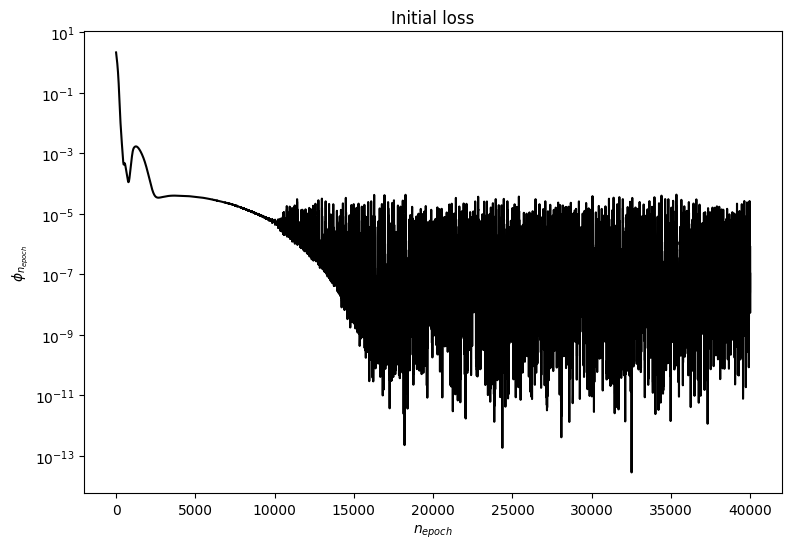

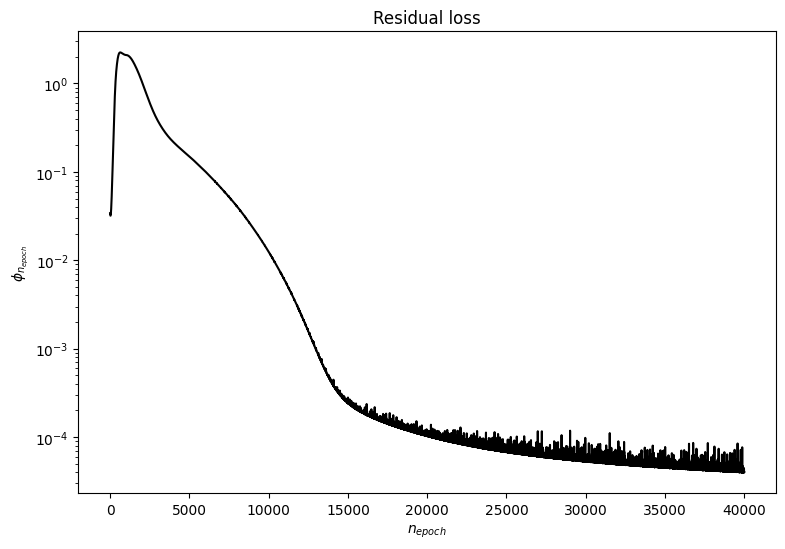

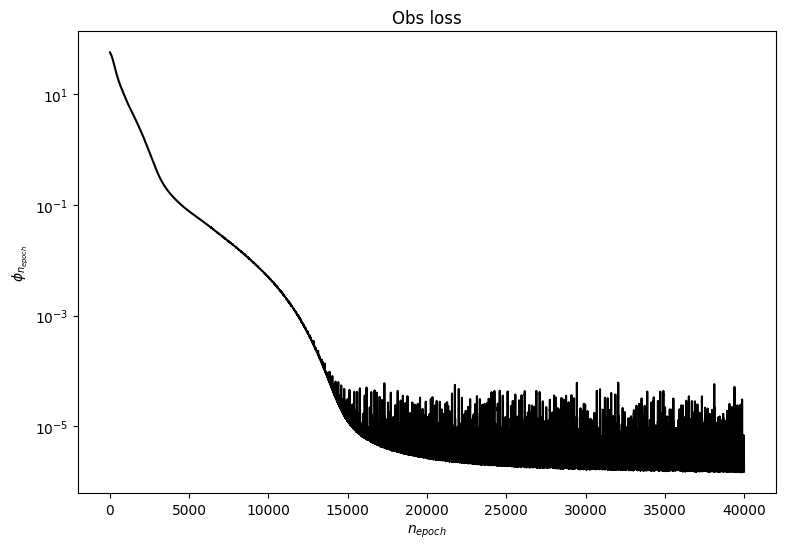

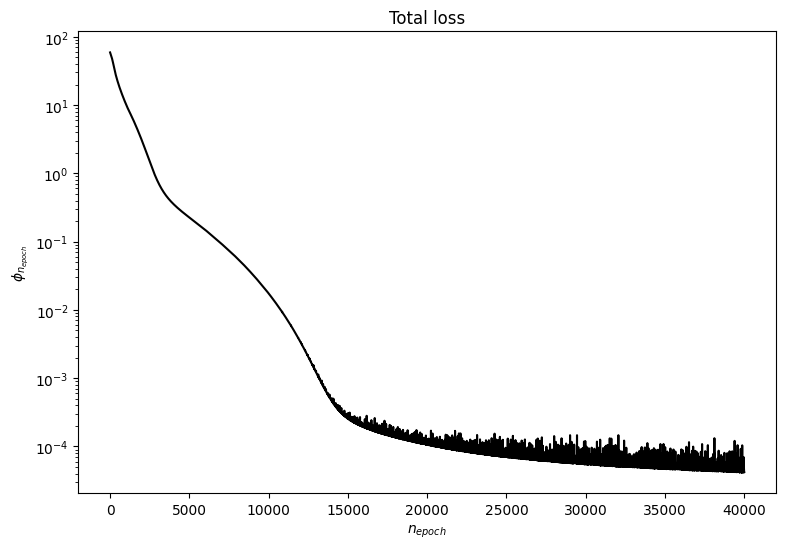

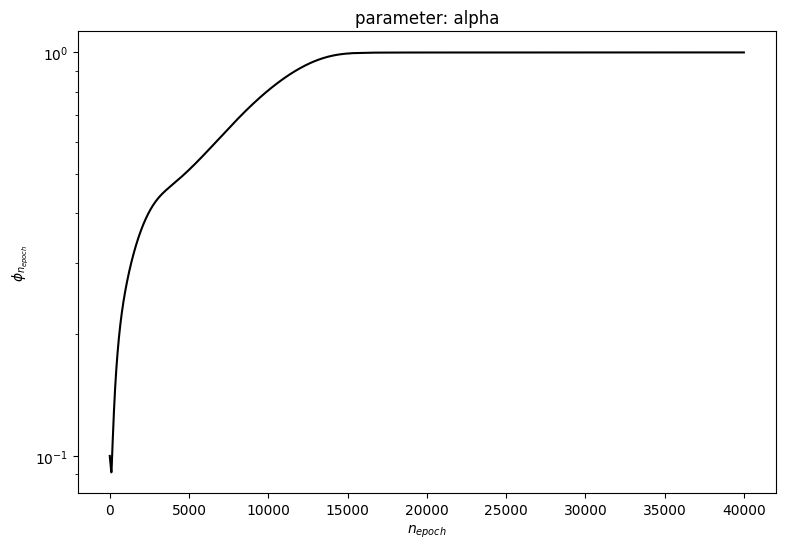

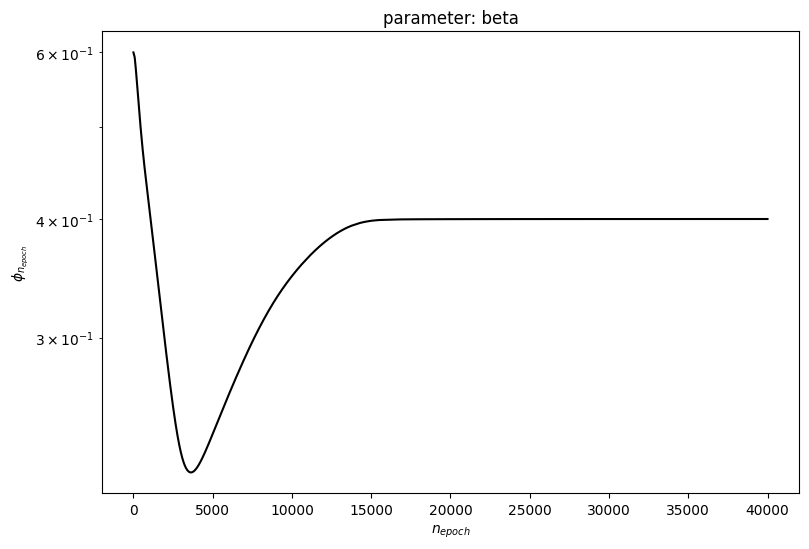

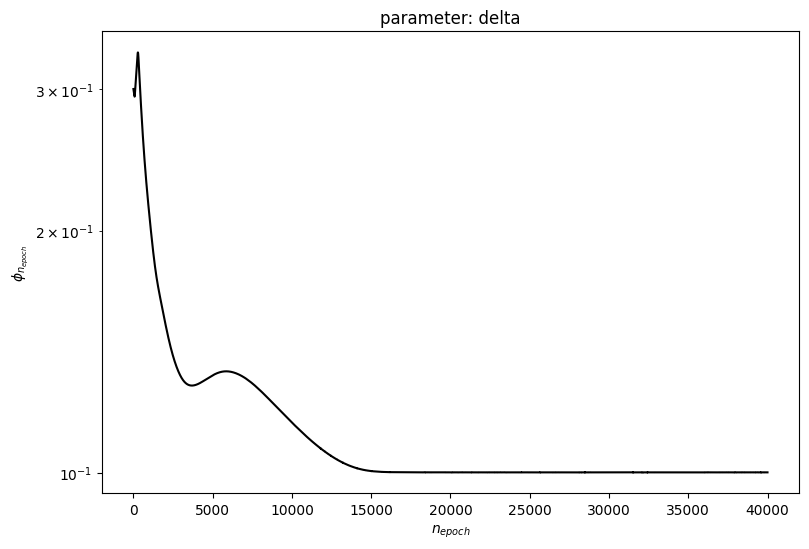

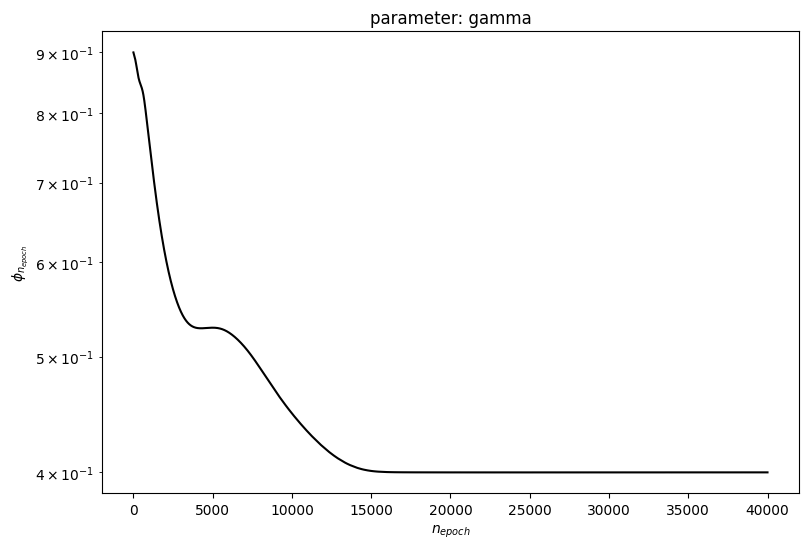

In [8]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[0])), model.hist[0],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Initial loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[1])), model.hist[1],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Residual loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[2])), model.hist[2],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Obs loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[3])), model.hist[3],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Total loss')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[4])), model.hist[4],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('parameter: alpha')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[5])), model.hist[5],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('parameter: beta')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[6])), model.hist[6],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('parameter: delta')

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(model.hist[7])), model.hist[7],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('parameter: gamma')

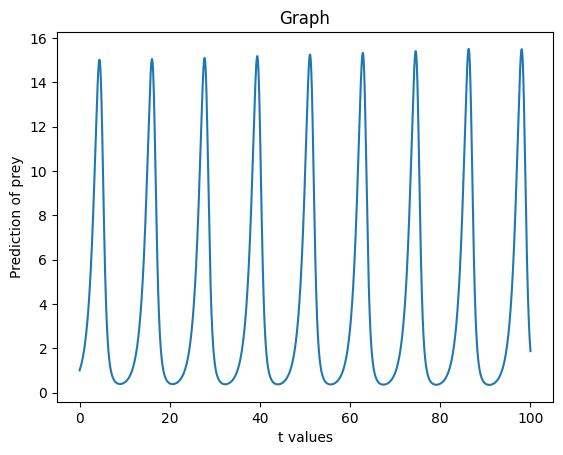

In [9]:
## Plot the function - U: the number of prey in this model
##

mesh_time = 20000
tspace = np.linspace(lb[0], ub[0], mesh_time+1)
T_tensor = torch.tensor(tspace, dtype=torch.float32).reshape(mesh_time+1, 1)
U_tensor = model.get_u(T_tensor)
uspace = U_tensor.detach().numpy().reshape(mesh_time+1)
plt.plot(tspace, uspace, '-')
plt.title('Graph')
plt.ylabel('Prediction of prey')
plt.xlabel('t values')
plt.show()


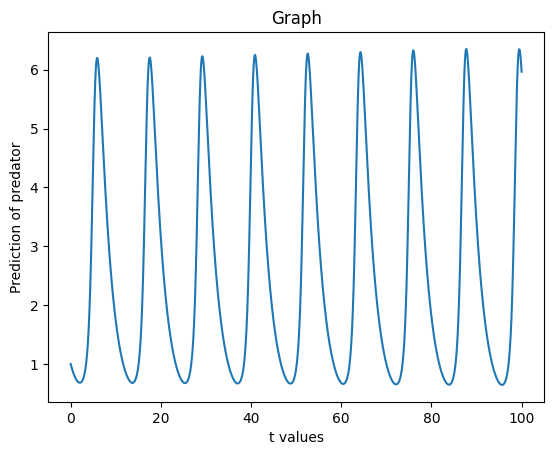

In [10]:
## Plot the function - U: the number of predators in this model
##
mesh_time = 20000
tspace = np.linspace(lb[0], ub[0], mesh_time+1)
T_tensor = torch.tensor(tspace, dtype=torch.float32).reshape(mesh_time+1, 1)
V_tensor = model.get_v(T_tensor)
vspace = V_tensor.detach().numpy().reshape(mesh_time+1)
plt.plot(tspace, vspace, '-')
plt.title('Graph')
plt.ylabel('Prediction of predator')
plt.xlabel('t values')
plt.show()


In [ ]:
############################################
#### Experiments: 2.1. Lotka-Volterra equation.

########## How about this Idea?
#### IC-forcing.
#### We should make u(0) == 1
#### And v(0) == 1
#### So, no IC loss, but always plug in u(0), v(0) == 1
#########################